In [ ]:
#Mounting google drive for loading the data 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing files to collab from drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create a PyDrive Client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Spark 
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz 

# Unzip the Spark file
!tar xf spark-3.3.1-bin-hadoop3.tgz

# Set your Spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

# Install findspark
!pip install -q findspark

# Install PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 50.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b73ae1a9f16ef3bece2eb5bc58c6e7db9ba89e4102657f1ed19993653a8c997f
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
#Creating Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').getOrCreate()

In [ ]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pandas.plotting import scatter_matrix
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.types as tp
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import BinaryType
from pyspark.sql import functions as F
import random

In [ ]:
#Loading the dataset & Checking datatype
df = spark.read.csv('/content/drive/MyDrive/IDS 561/PROJECT/globalterrorismdb_0221dist.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- eventid: double (nullable = true)
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- extended: integer (nullable = true)
 |-- country: integer (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: integer (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: integer (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- crit1: integer (nullable = true)
 |-- crit2: integer (nullable = true)
 |-- crit3: integer (nullable = true)
 |-- doubtterr: integer (nullable = true)
 |-- multiple: integer (nullable = true)
 |-- success: integer (nullable = true)
 |-- suicide: integer (nullable = true)
 |-- attacktype1: integer (nullable = true)
 |-- attacktype1_txt: string (nullable = true)
 |-- attacktype2: integer 

In [ ]:
#Count of rows and columns in the dataset.
print((df.count(),len(df.columns)))

(201183, 68)


## **EXPLORATORY DATA ANALYSIS**

In [ ]:
#Filtering data before 2012 due to unorganized data collection methodologies as mentioned in source website from where the dataset is taken.
df=df.filter(df.iyear > 2011)

In [ ]:
#Count of rows and columns in the dataset.
print((df.count(),len(df.columns)))

(96397, 68)


In [ ]:
#group attacks by year
df_n = df.groupBy("iyear").count().orderBy(col("count").desc())
df_n.show()

+-----+-----+
|iyear|count|
+-----+-----+
| 2014|16959|
| 2015|15133|
| 2016|14046|
| 2013|12045|
| 2017|11358|
| 2018| 9840|
| 2012| 8521|
| 2019| 8495|
+-----+-----+



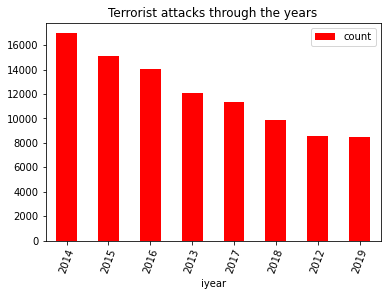

In [ ]:
df_n = df_n.toPandas()
df_n.plot.bar(x="iyear", y="count", rot=70, title="Terrorist attacks through the years", color = "r")

In [ ]:
#country with attacks in Descending Order
print("Global Terrorist Attacks data by country")
df_w = df.groupBy("country_txt").count().orderBy(col("count").desc())
df_w.show()

Global Terrorist Attacks data by country
+--------------------+-----+
|         country_txt|count|
+--------------------+-----+
|                Iraq|18921|
|         Afghanistan|13275|
|            Pakistan| 9686|
|               India| 6556|
|               Yemen| 5094|
|         Philippines| 4611|
|             Nigeria| 4494|
|             Somalia| 4068|
|               Syria| 2539|
|               Libya| 2470|
|            Thailand| 2273|
|               Egypt| 2089|
|             Ukraine| 1738|
|              Turkey| 1640|
|            Colombia| 1293|
|Democratic Republ...| 1025|
|          Bangladesh|  951|
|West Bank and Gaz...|  921|
|      United Kingdom|  822|
|                Mali|  810|
+--------------------+-----+
only showing top 20 rows



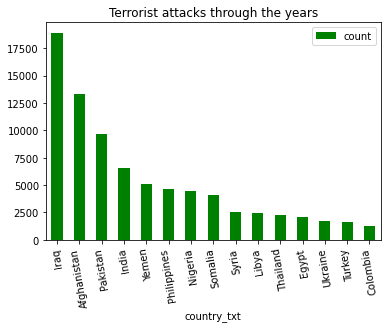

In [ ]:
# Plotting a graph to visualize the above table
df_w = df_w.toPandas()
top_15 = df_w.sort_values(by="count", ascending=False).head(15)
top_15.plot(x="country_txt", y="count", kind="bar", rot=100, title="Terrorist attacks through the years", fontsize=10, color = "g")

In [ ]:
#group by type of target
print("Target type vs Count")
df_x = df.groupBy("targtype1_txt").count().orderBy(col("count").desc())
df_x.show()

Target type vs Count
+--------------------+-----+
|       targtype1_txt|count|
+--------------------+-----+
|Private Citizens ...|26011|
|            Military|19799|
|              Police|14812|
|Government (General)| 8743|
|            Business| 6525|
|             Unknown| 5629|
|Religious Figures...| 2503|
|Terrorists/Non-St...| 2133|
|Educational Insti...| 2016|
|      Transportation| 1820|
|           Utilities| 1713|
| Journalists & Media| 1227|
|Violent Political...| 1091|
|Government (Diplo...|  870|
|                 NGO|  445|
|   Telecommunication|  405|
| Airports & Aircraft|  229|
|            Maritime|  114|
|Food or Water Supply|  110|
|               Other|  105|
+--------------------+-----+
only showing top 20 rows



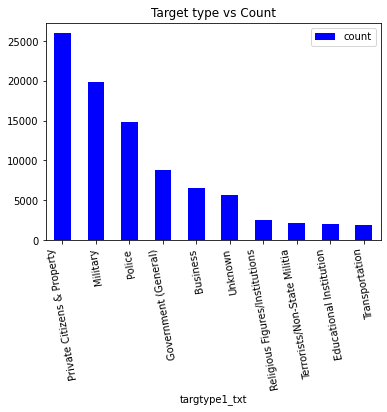

In [ ]:
# Plotting a graph to visualize the above table
df_x = df_x.toPandas()
top_10 = df_x.sort_values(by="count", ascending=False).head(10)
top_10.plot(x="targtype1_txt", y="count", kind="bar", rot=100, title="Target type vs Count", fontsize=10, color = "b")

In [ ]:
#group by attack type by count in different years
print("Attack type vs Count")
df_a = df.groupBy("attacktype1_txt").count().orderBy(col("count").desc())
df_a.show()

Attack type vs Count
+--------------------+-----+
|     attacktype1_txt|count|
+--------------------+-----+
|   Bombing/Explosion|47512|
|       Armed Assault|22316|
|Hostage Taking (K...| 7633|
|       Assassination| 6385|
|             Unknown| 6174|
|Facility/Infrastr...| 5088|
|     Unarmed Assault|  558|
|Hostage Taking (B...|  446|
|           Hijacking|  285|
+--------------------+-----+



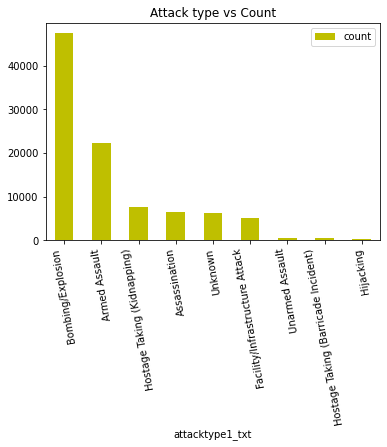

In [ ]:
df_a = df_a.toPandas()
top_10 = df_a.sort_values(by="count", ascending=False).head(10)
top_10.plot(x="attacktype1_txt", y="count", kind="bar", rot=100, title="Attack type vs Count", fontsize=10, color = "y")

In [ ]:
##group by region by count in different years
print("Region vs Count")
df_r = df.groupBy("region_txt").count().orderBy(col("count").desc())
df_r.show()

Region vs Count
+--------------------+-----+
|          region_txt|count|
+--------------------+-----+
|Middle East & Nor...|35785|
|          South Asia|31395|
|  Sub-Saharan Africa|14691|
|      Southeast Asia| 7620|
|      Eastern Europe| 2351|
|      Western Europe| 1961|
|       South America| 1699|
|       North America|  565|
|           East Asia|  128|
|        Central Asia|   73|
|Australasia & Oce...|   71|
|Central America &...|   58|
+--------------------+-----+



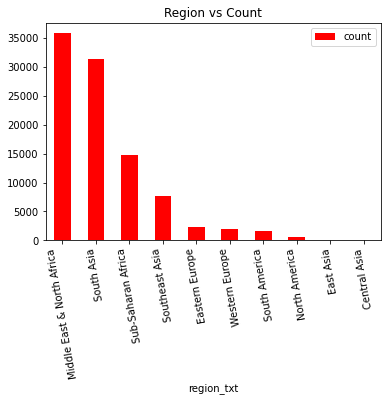

In [ ]:
df_r = df_r.toPandas()
top_10 = df_r.sort_values(by="count", ascending=False).head(10)
top_10.plot(x="region_txt", y="count", kind="bar", rot=100, title="Region vs Count", fontsize=10, color = "r")

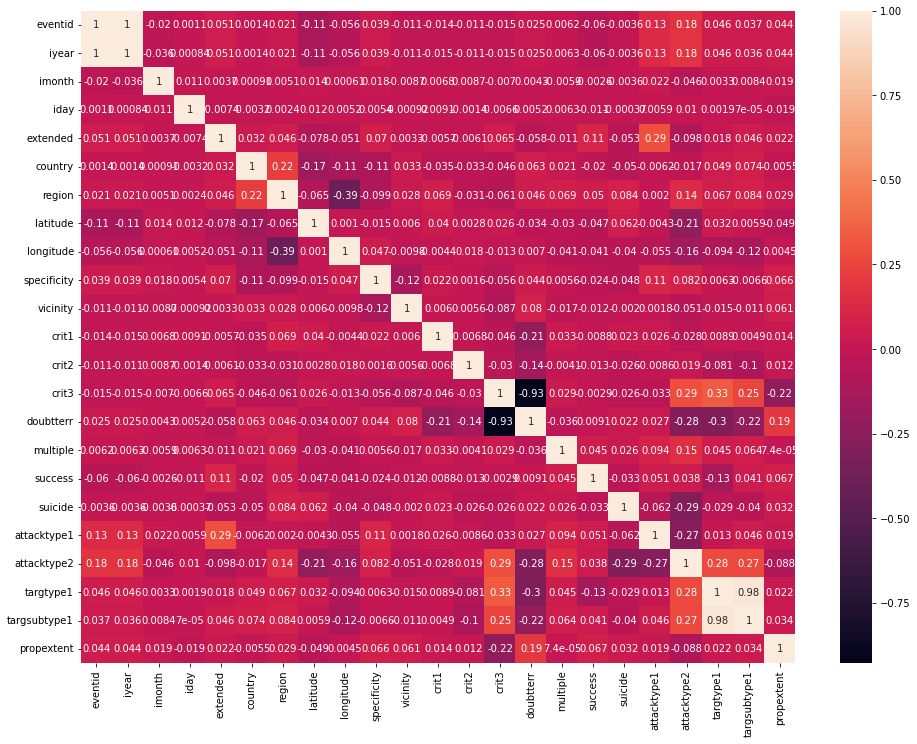

In [ ]:
#Correlation Matrix
%matplotlib inline
df_pd = df.toPandas()
pd.set_option('display.max_columns',500)
plt.figure(figsize=(16, 12))
sb.heatmap(df_pd.corr(),annot = True)

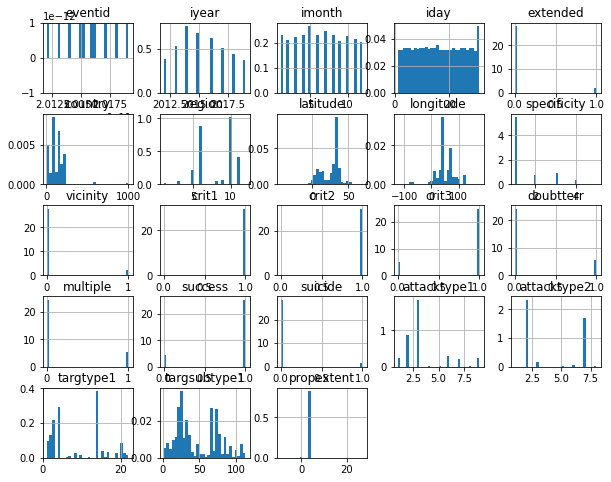

In [ ]:
#Visualize the variable distribution with histograms
df_pd.hist(bins=30, figsize=(10,8), density=True)
plt.show()

In [ ]:
#Feature Selection
df=df.select(df.success,df.iyear,df.imonth,df.targtype1,df.gname,df.attacktype1,df.extended,df.country,df.region,df.vicinity,df.crit1,df.suicide,df.specificity,df.doubtterr,df.multiple)
df.show()

+-------+-----+------+---------+--------------------+-----------+--------+-------+------+--------+-----+-------+-----------+---------+--------+
|success|iyear|imonth|targtype1|               gname|attacktype1|extended|country|region|vicinity|crit1|suicide|specificity|doubtterr|multiple|
+-------+-----+------+---------+--------------------+-----------+--------+-------+------+--------+-----+-------+-----------+---------+--------+
|      1| 2012|     1|        1|             Unknown|          3|       0|    153|     6|       0|    1|      0|          1|        0|       0|
|      1| 2012|     1|        1|          Al-Shabaab|          2|       0|    104|    11|       0|    1|      0|          1|        0|       1|
|      1| 2012|     1|        4|Baloch Republican...|          3|       0|    153|     6|       0|    1|      0|          1|        1|       0|
|      1| 2012|     1|        1|          Al-Shabaab|          2|       0|    104|    11|       0|    1|      0|          1|        0|  

In [ ]:
#get count of null values
print("get count of null values")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

get count of null values
+-------+-----+------+---------+-----+-----------+--------+-------+------+--------+-----+-------+-----------+---------+--------+
|success|iyear|imonth|targtype1|gname|attacktype1|extended|country|region|vicinity|crit1|suicide|specificity|doubtterr|multiple|
+-------+-----+------+---------+-----+-----------+--------+-------+------+--------+-----+-------+-----------+---------+--------+
|      0|    0|     0|        0|    0|          0|       0|      0|     0|       0|    0|      0|          0|        0|       0|
+-------+-----+------+---------+-----+-----------+--------+-------+------+--------+-----+-------+-----------+---------+--------+



In [ ]:
#Checking datatype
df.printSchema()

root
 |-- success: integer (nullable = true)
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- targtype1: integer (nullable = true)
 |-- gname: string (nullable = true)
 |-- attacktype1: integer (nullable = true)
 |-- extended: integer (nullable = true)
 |-- country: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- crit1: integer (nullable = true)
 |-- suicide: integer (nullable = true)
 |-- specificity: integer (nullable = true)
 |-- doubtterr: integer (nullable = true)
 |-- multiple: integer (nullable = true)



In [ ]:
#Remnaming succes as label & Checked respective count of success (1) & No success (0)
new_df = df.withColumnRenamed('success', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,1,81839
1,0,14558


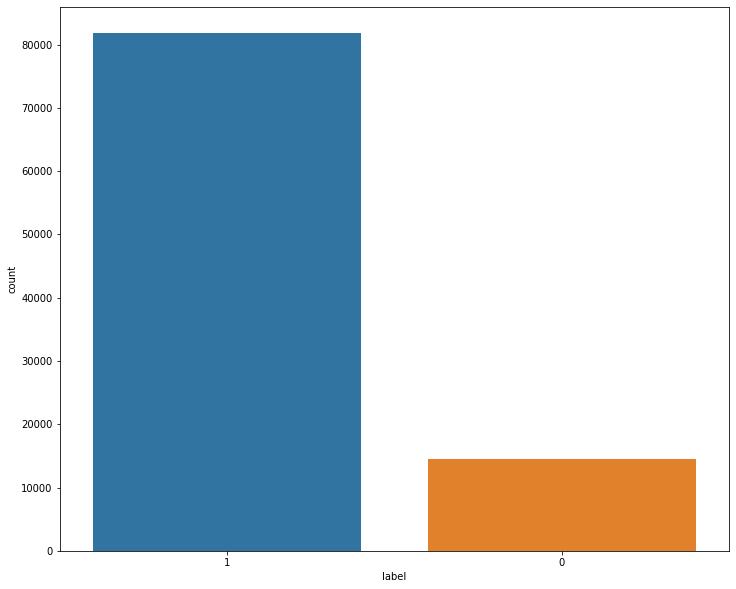

In [ ]:
#Imbalance data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = new_df.toPandas()
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

In [ ]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,iyear,imonth,targtype1,gname,attacktype1,extended,country,region,vicinity,crit1,suicide,specificity,doubtterr,multiple
0,1,2012,1,1,Unknown,3,0,153,6,0,1,0,1,0,0
1,1,2012,1,1,Al-Shabaab,2,0,104,11,0,1,0,1,0,1
2,1,2012,1,4,Baloch Republican Army (BRA),3,0,153,6,0,1,0,1,1,0
3,1,2012,1,1,Al-Shabaab,2,0,104,11,0,1,0,1,0,1
4,1,2012,1,14,Unknown,6,1,153,6,0,1,0,1,0,0
5,1,2012,1,17,Unknown,3,0,153,6,0,1,0,1,0,0
6,0,2012,1,2,Unknown,1,0,95,10,1,1,0,1,0,0
7,1,2012,1,4,Taliban,3,0,4,6,0,1,0,2,1,0
8,0,2012,1,20,Unknown,3,0,4,6,0,1,0,2,0,0
9,1,2012,1,14,Unknown,3,0,153,6,1,1,0,1,0,0


In [ ]:
# now let's see how many categorical and numerical features we have:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
print(cat_cols)
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')
print(num_cols)

1  categorical features
['gname']
13  numerical features
['iyear', 'imonth', 'targtype1', 'attacktype1', 'extended', 'country', 'region', 'vicinity', 'crit1', 'suicide', 'specificity', 'doubtterr', 'multiple']


In [ ]:
#Checking columns with no missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe

    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
    #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 

    #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
missings = info_missing_table(df_pd)
missings


Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
#Countering imbalance using weight balancing.
ratio=0.87              #inverse ratio of both classes
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
new_df = new_df.withColumn('weights', weight_balance(col('label')))
print(new_df)

DataFrame[label: int, iyear: int, imonth: int, targtype1: int, gname: string, attacktype1: int, extended: int, country: int, region: int, vicinity: int, crit1: int, suicide: int, specificity: int, doubtterr: int, multiple: int, weights: double]


## **Machine Learning Model building & Evaluation**

In [ ]:
#Feature engineering
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols                                     #combine numerical and categorical features into a single vector as "features"
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
#Pipeline model

from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

,features,label,iyear,imonth,targtype1,gname,attacktype1,extended,country,region,vicinity,crit1,suicide,specificity,doubtterr,multiple,weights
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2012,1,1,Unknown,3,0,153,6,0,1,0,1,0,0,0.87
1,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2012,1,1,Al-Shabaab,2,0,104,11,0,1,0,1,0,1,0.87
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2012,1,4,Baloch Republican Army (BRA),3,0,153,6,0,1,0,1,1,0,0.87
3,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2012,1,1,Al-Shabaab,2,0,104,11,0,1,0,1,0,1,0.87
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2012,1,14,Unknown,6,1,153,6,0,1,0,1,0,0,0.87


In [ ]:
# split the data into trainign and testing sets
train, test = new_df.randomSplit([0.70, 0.30], seed = 42)
print(train.count())
print(test.count())
#LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)

67687
28710


## **Logistic Regression Model & Evaluation**

In [ ]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)
predictions_LR_Tr = LR_model.transform(train)
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()


eval_accuracy_LR = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1_LR = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy_LR = eval_accuracy_LR.evaluate(predictions_LR)
accuracy_LR_Tr = eval_accuracy_LR.evaluate(predictions_LR_Tr)
f1score_LR = eval_f1_LR.evaluate(predictions_LR)

print('Logistic Regression Training Accuracy:', accuracy_LR_Tr)
print('Logistic Regression Testing Accuracy:', accuracy_LR)
print("Logistic Regression AUC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))
print('Logistic Regression F1:', f1score_LR)

Logistic Regression Training Accuracy: 0.8514485794908919
Logistic Regression Testing Accuracy: 0.846569139672588
Logistic Regression AUC: 0.7020128231852979
Logistic Regression F1: 0.7806953971357621


# **Gradient Boost Model & Evaluation**

In [ ]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=15)
GBT_Model = gbt.fit(train)
predictions_gbt_Tr = GBT_Model.transform(train)
predictions_gbt = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()

eval_accuracy_gb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1_gb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy_gb_Tr = eval_accuracy_gb.evaluate(predictions_gbt_Tr)
accuracy_gb = eval_accuracy_gb.evaluate(predictions_gbt)
f1score_gb = eval_f1_gb.evaluate(predictions_gbt)

print('Gradient Boost Training Accuracy:', accuracy_gb_Tr)
print('Gradient Boost Testing Accuracy:', accuracy_gb)
print("Gradient Boost AUC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))
print('Gradient Boost F1:', f1score_gb)


Gradient Boost Training Accuracy: 0.8819714273050955
Gradient Boost Testing Accuracy: 0.8779519331243469
Gradient Boost AUC: 0.8332267482008646
Gradient Boost F1: 0.8572854358500532


# **Naive Bayes Model & Evaluation**

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb = nb.fit(train)
pred_Tr = nb.transform(train)
pred = nb.transform(test)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)

eval_accuracy_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy_nb = eval_accuracy_nb.evaluate(pred)
accuracy_nb_Tr = eval_accuracy_nb.evaluate(pred_Tr)
f1score_nb = eval_f1_nb.evaluate(pred)

print('Naive Bayes Training Accuracy:', accuracy_nb_Tr)
print('Naive Bayes Testing Accuracy:', accuracy_nb)
print("Naive Bayes AUC:" ,acc)
print('Naive Bayes F1:', f1score_nb)

Naive Bayes Training Accuracy: 0.7267865321258145
Naive Bayes Testing Accuracy: 0.7298850574712644
Naive Bayes AUC: 0.7473265410631255
Naive Bayes F1: 0.7473265410631255


# **Random Forest Model & Evaluation**


In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions_rf_Tr = rfModel.transform(train)
predictions_rf = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator()

eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy = eval_accuracy.evaluate(predictions_rf)
accuracy_Tr = eval_accuracy.evaluate(predictions_rf_Tr)
f1score = eval_f1.evaluate(predictions_rf)

print('Random Forest Training Accuracy:', accuracy_Tr)
print('Random Forest Testing Accuracy:', accuracy)
print("Random Forest AUC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))
print('Random Forest F1:', f1score)

Random Forest Training Accuracy: 0.8497348087520499
Random Forest Testing Accuracy: 0.8471960989202368
Random Forest AUC: 0.7292093179400285
Random Forest F1: 0.7771142765461853
